In [1]:
from IPython.core.display import HTML
display(HTML('<style>.container { width:95% !important; } </style>'))

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from tqdm import tqdm_notebook as tqdm
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

## Load data

In [3]:
from scipy.stats import triang
distr = triang(loc=-1, scale=2, c=0.5)
N = int(1e5)
samples = distr.rvs(size=N)
lower_bound, upper_bound = -1, 1

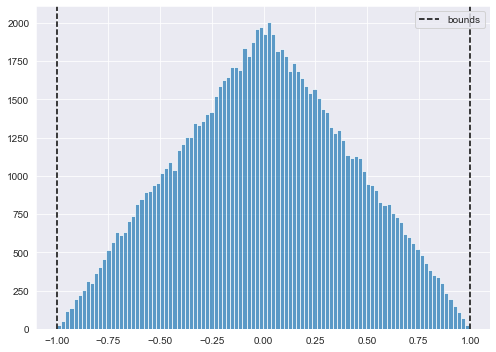

In [4]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)
    
    ax.hist(samples, bins=100, alpha=0.7)
    ax.axvline(x=lower_bound, color='black', linestyle='--')
    ax.axvline(x=upper_bound, color='black', linestyle='--', label='bounds')
    ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

## Concentration bounds

In [5]:
from concentration_lib import hoeffding_bound, bernstein_bound, bentkus_bound

def concentration_upper_bounds(sample: np.array, N: int, M: int, delta: float = 0.05, params: dict = {}, n_start: int = 1, verbose: bool = False):
    """
    sample: np.array
    Size must be at least N * M.
    
    N: int
    Sample size for a given estimator.
    
    M: int
    Number of independent repetitions.
    
    delta: float
    Confidence level.
    
    params: dict
    Parameters that influence concentration (bounds, variance, sub-Gaussian...).
    
    n_start: int
    Start computing concentration bounds when sample size is >= n_start.
    
    verbose: bool
    For tqdm.
    """
    from scipy.stats import norm
    
    sample = sample[:N * M].reshape((N, M))
    
    S = np.zeros((N, M))
    upper_bound_hoeffding = np.zeros(N) * np.nan    
    upper_bound_bernstein = np.zeros(N) * np.nan
    upper_bound_bernstein_no_var = np.zeros(N) * np.nan
    upper_bound_bentkus = np.zeros(N) * np.nan
    upper_bound_bentkus_no_var = np.zeros(N) * np.nan

    boundary_crossings_hoeffding = np.zeros((N, M)) * np.nan    
    boundary_crossing_hoeffding = np.zeros(N) * np.nan    
    boundary_crossings_bernstein = np.zeros((N, M)) * np.nan
    boundary_crossing_bernstein = np.zeros(N) * np.nan
    boundary_crossings_bernstein_no_var = np.zeros((N, M)) * np.nan
    boundary_crossing_bernstein_no_var = np.zeros(N) * np.nan
    boundary_crossings_bentkus = np.zeros((N, M)) * np.nan
    boundary_crossing_bentkus = np.zeros(N) * np.nan
    boundary_crossings_bentkus_no_var = np.zeros((N, M)) * np.nan
    boundary_crossing_bentkus_no_var = np.zeros(N) * np.nan
    
    B = params.get('B')
    sigma = params.get('sigma')

    for n in tqdm(range(N), disable=not verbose):
        if n >= n_start:
            upper_bound_hoeffding[n] = hoeffding_bound(delta, n + 1, B, mode='sum')
            upper_bound_bernstein[n] = bernstein_bound(delta, n + 1, sigma, B, mode='sum')
            upper_bound_bernstein_no_var[n] = bernstein_bound(delta, n + 1, B, B, mode='sum')
            upper_bound_bentkus[n] = bentkus_bound(delta, n, sigma, B, mode='sum')
            upper_bound_bentkus_no_var[n] = bentkus_bound(delta, n, B, B, mode='sum')

        for m in range(M):
            S[n, m] = np.sum(sample[:n, m])
            if n >= n_start:
                boundary_crossings_hoeffding[n, m] = S[n, m] > upper_bound_hoeffding[n]
                boundary_crossings_bernstein[n, m] = S[n, m] > upper_bound_bernstein[n]
                boundary_crossings_bernstein_no_var[n, m] = S[n, m] > upper_bound_bernstein_no_var[n]
                boundary_crossings_bentkus[n, m] = S[n, m] > upper_bound_bentkus[n]
                boundary_crossings_bentkus_no_var[n, m] = S[n, m] > upper_bound_bentkus_no_var[n]

            if n >= n_start:
                boundary_crossing_hoeffding[n] = np.mean(boundary_crossings_hoeffding[n, :])
                boundary_crossing_bernstein[n] = np.mean(boundary_crossings_bernstein[n, :])
                boundary_crossing_bernstein_no_var[n] = np.mean(boundary_crossings_bernstein_no_var[n, :])
                boundary_crossing_bentkus[n] = np.mean(boundary_crossings_bentkus[n, :])
                boundary_crossing_bentkus_no_var[n] = np.mean(boundary_crossings_bentkus_no_var[n, :])
    
    return {
        'random_walk': S,
        'bound': {
            'hoeffding': upper_bound_hoeffding,
            'bernstein': upper_bound_bernstein,
            'bernstein_no_var': upper_bound_bernstein_no_var,
            'bentkus': upper_bound_bentkus,
            'bentkus_no_var': upper_bound_bentkus_no_var,
        },
        'boundary_crossing': {
            'hoeffding': boundary_crossing_hoeffding,
            'bernstein': boundary_crossing_bernstein,
            'bernstein_no_var': boundary_crossing_bernstein_no_var,
            'bentkus': boundary_crossing_bentkus,
            'bentkus_no_var': boundary_crossing_bentkus_no_var,
        }
    }

In [6]:
M = 100
sample_idx = 0
params = {'B': upper_bound, 'sigma': distr.std()}
delta = 0.05

concentration_dict_200 = concentration_upper_bounds(samples, 200, M, delta, params, n_start = 5, verbose=True)

/home/sauxpa/github/concentration/concentration_lib/concentration_bounds.py:150: RuntimeWarning: invalid value encountered in true_divide
  psi = (v - kk * e) / (e - kk * p)
/home/sauxpa/github/concentration/concentration_lib/concentration_bounds.py:150: RuntimeWarning: divide by zero encountered in true_divide
  psi = (v - kk * e) / (e - kk * p)


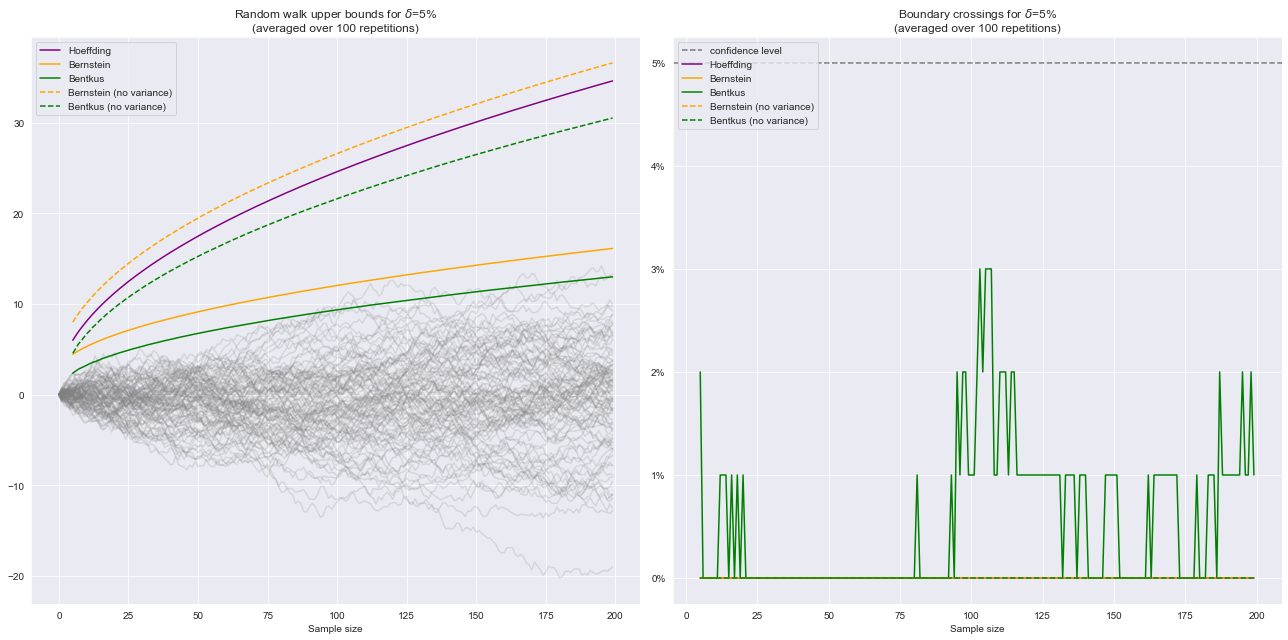

In [7]:
with sns.axes_style('darkgrid'):
    fig, axes = plt.subplots(figsize=(18, 9), nrows=1, ncols=2)

    ax = axes[0]
    ax.plot(concentration_dict_200['random_walk'], color='grey', alpha=0.2)
    ax.plot(concentration_dict_200['bound']['hoeffding'], color='purple', label='Hoeffding')
    ax.plot(concentration_dict_200['bound']['bernstein'], color='orange', label='Bernstein')
    ax.plot(concentration_dict_200['bound']['bentkus'], color='green', label='Bentkus')
    ax.plot(concentration_dict_200['bound']['bernstein_no_var'], color='orange', linestyle='dashed', label='Bernstein (no variance)')
    ax.plot(concentration_dict_200['bound']['bentkus_no_var'], color='green', linestyle='dashed', label='Bentkus (no variance)')
    
    ax.set_xlabel('Sample size')
    ax.legend(loc='upper left')
    ax.set_title('Random walk upper bounds for $\delta$={:.0%}\n(averaged over {:.0f} repetitions)'.format(delta, M))
    
    ax = axes[1]
    ax.axhline(y=delta, color='black', linestyle='dashed', label='confidence level', alpha=0.5)
    ax.plot(concentration_dict_200['boundary_crossing']['hoeffding'], color='purple', label='Hoeffding')
    ax.plot(concentration_dict_200['boundary_crossing']['bernstein'], color='orange', label='Bernstein')
    ax.plot(concentration_dict_200['boundary_crossing']['bentkus'], color='green', label='Bentkus')
    ax.plot(concentration_dict_200['boundary_crossing']['bernstein_no_var'], color='orange', linestyle='dashed', label='Bernstein (no variance)')
    ax.plot(concentration_dict_200['boundary_crossing']['bentkus_no_var'], color='green', linestyle='dashed', label='Bentkus (no variance)')
    
    ax.set_xlabel('Sample size')
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    ax.legend(loc='upper left')
    ax.set_title('Boundary crossings for $\delta$={:.0%}\n(averaged over {:.0f} repetitions)'.format(delta, M))
    
    plt.tight_layout()
    plt.show()